In [1]:
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from os.path import join, isdir, dirname, abspath
from os import listdir
from typing import List
from pathlib import Path
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from collections import OrderedDict
import torch
from scipy.stats import linregress

from matplotlib import colors


root_path = dirname(abspath("./"))
import sys
sys.path.append(root_path)

from prochain_transformer.subroutines.eval_sweeps import get_df_recursive, has_logs_subfolder, get_df_kfold_loss
from prochain_transformer.predict import get_features_gradients
from prochain_transformer.modules.utils import find_last_checkpoint
from prochain_transformer.experiment_control import update_config
from prochain_transformer.forecaster import TransformerForecaster

In [2]:
def post_process_sweep(
    df: pd.DataFrame,
    compound_cols: List[dict],
    columns_name_map: dict=None,
    columns_to_dump: list=None
    ):
    
    df_ = df.copy()
    
    # extract sweeps and base info
    for compound_col in compound_cols:
        df_[compound_col["new_label"]] = df_[compound_col["old_label"]].str.extract(compound_col["regex"])
        df_[compound_col["new_label"]] = df_[compound_col["new_label"]].astype(compound_col["type"])
        
    if columns_name_map is not None:
        df_ = df_.rename(columns=columns_name_map)
        
    if columns_to_dump is not None:
        df_ = df_.drop(columns=columns_to_dump)
        
    return df_

In [3]:
# load params count dataframe
df_count_sum = pd.read_csv("../experiments/evaluations/dx_250618_sum/model_size/df_params_count")
df_count_cat = pd.read_csv("../experiments/evaluations/dx_250618_cat/model_size/df_params_count")
df_count_st = pd.read_csv("../experiments/evaluations/dx_250618_stformer/model_size/df_params_count")

# load loss dataframe
dirpath_sum = "../experiments/training/dx_250618_sum"
dirpath_cat = "../experiments/training/dx_250618_cat"
dirpath_st = "../experiments/training/dx_250618_stformer"
df_loss_sum = get_df_recursive(filepath=dirpath_sum, bottom_action=get_df_kfold_loss, is_bottom= has_logs_subfolder)
df_loss_cat = get_df_recursive(filepath=dirpath_cat, bottom_action=get_df_kfold_loss, is_bottom= has_logs_subfolder)
df_loss_st = get_df_recursive(filepath=dirpath_st, bottom_action=get_df_kfold_loss, is_bottom= has_logs_subfolder)

In [4]:
df_loss_st

,k,val_loss,train_loss,test_loss,level_3,level_2,level_1,level_0
0,k_0,0.018241,0.010615,0.013038,sweep_dec_time_emb_hidden_0,sweep_dec_time_emb_hidden,sweeps,mod100
1,k_1,0.015598,0.011017,0.014727,sweep_dec_time_emb_hidden_0,sweep_dec_time_emb_hidden,sweeps,mod100
2,k_2,0.021752,0.010863,0.014066,sweep_dec_time_emb_hidden_0,sweep_dec_time_emb_hidden,sweeps,mod100
3,k_3,0.015299,0.010674,0.013205,sweep_dec_time_emb_hidden_0,sweep_dec_time_emb_hidden,sweeps,mod100
4,k_4,0.023203,0.009005,0.019200,sweep_dec_time_emb_hidden_0,sweep_dec_time_emb_hidden,sweeps,mod100
...,...,...,...,...,...,...,...,...
0,k_0,0.019084,0.010625,0.012531,sweep_enc_val_emb_hidden_50,sweep_enc_val_emb_hidden,sweeps,mod50
1,k_1,0.025466,0.009312,0.012968,sweep_enc_val_emb_hidden_50,sweep_enc_val_emb_hidden,sweeps,mod50
2,k_2,0.023021,0.009565,0.015117,sweep_enc_val_emb_hidden_50,sweep_enc_val_emb_hidden,sweeps,mod50
3,k_3,0.018128,0.011218,0.017648,sweep_enc_val_emb_hidden_50,sweep_enc_val_emb_hidden,sweeps,mod50


In [5]:
columns_name_map_count = {
    "level_2": "sweep variable"
}

columns_name_map_loss = {
    "val_loss"  : "validation",
    "train_loss"  : "train",
    "test_loss"  : "test",
    "level_2": "sweep variable"
    }

compound_cols_sum = [
        {
            "old_label":"level_3", 
            "new_label":"sweep value", 
            "regex":r"(\d+)$", 
            "type":float
            },
        {
            "old_label" :"level_0",
            "new_label": "model base",
            "regex":r"(\d+)$", 
            "type":float}
        ]

compound_cols_cat = [
        {
            "old_label":"level_3", 
            "new_label":"sweep value", 
            "regex":r"(\d+)$", 
            "type":float
            },
        {
            "old_label" :"level_0",
            "new_label": ["embedding base", "model base"],
            "regex":r"^emb(\d+)_mod(\d+)$",  
            "type":float}
        ]

compound_cols_st = [
        {
            "old_label":"level_3", 
            "new_label":"sweep value", 
            "regex":r"(\d+)$", 
            "type":float
            },
        {
            "old_label" :"level_0",
            "new_label": "model base",
            "regex":r"(\d+)$", 
            "type":float}
        ]

columns_to_dump = [
    "level_0",
    "level_1",
    "level_3"
]

# params count dataframes
df_C_sum = post_process_sweep(df_count_sum, compound_cols_sum, columns_name_map_count,columns_to_dump)
df_C_cat = post_process_sweep(df_count_cat, compound_cols_cat, columns_name_map_count,columns_to_dump)
df_C_st = post_process_sweep(df_count_st, compound_cols_st, columns_name_map_count,columns_to_dump)

# loss dataframes
df_L_sum = post_process_sweep(df_loss_sum, compound_cols_sum, columns_name_map_loss, columns_to_dump)
df_L_cat = post_process_sweep(df_loss_cat, compound_cols_cat, columns_name_map_loss, columns_to_dump)
df_L_st = post_process_sweep(df_loss_st, compound_cols_st, columns_name_map_loss,columns_to_dump)

group_cols_sum = ["model base", "sweep variable", "sweep value"]
group_cols_st = ["model base", "sweep variable", "sweep value"]
group_cols_cat = ["model base", "embedding base","sweep variable", "sweep value"]
value_cols = ["train", "validation", "test"]

df_L_sum_stat = df_L_sum.groupby(group_cols_sum).agg({col:["mean", "std"] for col in value_cols}).reset_index()
df_L_sum_stat.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in df_L_sum_stat.columns]
df_L_cat_stat = df_L_cat.groupby(group_cols_cat).agg({col:["mean", "std"] for col in value_cols}).reset_index()
df_L_cat_stat.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in df_L_cat_stat.columns]
df_L_st_stat = df_L_st.groupby(group_cols_st).agg({col:["mean", "std"] for col in value_cols}).reset_index()
df_L_st_stat.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in df_L_st_stat.columns]

# merge dataframes
index_columns = ["model base", "sweep variable", "sweep value"]
df_sum = pd.merge(df_C_sum, df_L_sum_stat, on=group_cols_sum, how='inner')
df_sum["combination"] = "sum"
df_cat = pd.merge(df_C_cat, df_L_cat_stat, on=group_cols_cat, how='inner')
df_cat["combination"] = "cat"
df_st = pd.merge(df_C_st, df_L_st_stat, on=group_cols_st, how='inner')
df_st["combination"] = "st"

In [6]:
df = pd.concat([df_sum,df_cat,df_st],axis=0, ignore_index=True)

In [7]:
df_plot = df.copy()

df_plot["J2"] = df_plot["total_params"]/df_plot["total_params"].max()
df_plot["train_raw"] = df_plot["train_std"]+df_plot["train_mean"]
df_plot["val_raw"] = df_plot["validation_std"]+df_plot["validation_mean"]
df_plot["test_raw"] = df_plot["test_std"]+df_plot["test_mean"]
df_plot["J1_raw"] = (df_plot["val_raw"]+df_plot["test_raw"])/2

df_plot["J1"] = df_plot["J1_raw"]/df_plot["J1_raw"].max()

In [8]:
def extract_pareto_front(df, col1='J1', col2='J2'):
    """
    Extract Pareto front from DataFrame for MINIMIZATION of two objectives.
    Returns Pareto-optimal rows as a new DataFrame.
    """
    data = df[[col1, col2]].values
    is_pareto = np.ones(data.shape[0], dtype=bool)

    for i, point in enumerate(data):
        if is_pareto[i]:
            # Remove any point that is *better* (i.e., has lower J1 and J2)
            is_dominated = np.all(data <= point, axis=1) & np.any(data < point, axis=1)
            # ⚠️ key change: mark current point as dominated if *another point* dominates *it*
            if np.any(is_dominated & (np.arange(len(data)) != i)):
                is_pareto[i] = False

    pareto_df = df[is_pareto].copy()
    return pareto_df.sort_values([col1, col2]).reset_index(drop=True)




df_copy = df_plot.copy()
df_par = extract_pareto_front(df=df_copy, col1="J1", col2="J2")
df_par['distance_to_origin'] = (df_par['J1']**2 + df_par['J2']**2)**0.5
best_point = df_par.loc[df_par['distance_to_origin'].idxmin()]
x_best = best_point['J1']
y_best = best_point['J2']

In [10]:
best_point

Unnamed: 0                                   0
total_params                             71862
trainable_params                         71862
group_1_params                            8520
group_2_params                           63342
enc_emb_params                            8600
dec_emb_params                             180
total_emb_params                          8780
sweep variable        sweep_enc_pos_emb_hidden
sweep value                               20.0
model base                                20.0
train_mean                            0.000294
train_std                             0.000101
validation_mean                       0.006406
validation_std                        0.001299
test_mean                             0.001921
test_std                               0.00112
combination                                cat
embedding base                            20.0
J2                                     0.02953
train_raw                             0.000395
val_raw      

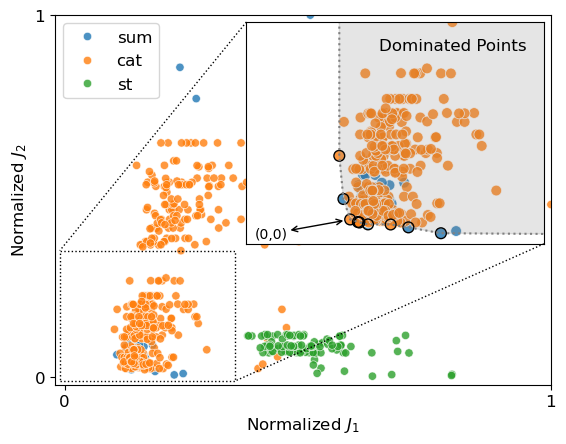

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
ax = sns.scatterplot(df_plot, x="J1", y="J2", hue="combination", marker = "o", alpha=0.8)


ax.set_xlim(-0.02, 1)
ax.set_ylim(-0.02, 1)
ax.set_ylabel("Normalized $J_2$",size=12)
ax.set_xlabel("Normalized $J_1$",size=12)
ax.set_yticks([0,1],labels=[0,1], size=12)
ax.set_xticks([0,1],labels=[0,1], size=12)

# ax.legend(loc='lower right',  title="Fusion", fontsize=12, title_fontsize=12)


legend = ax.legend(loc='upper left', fontsize=12)
legend.set_zorder(10)  # Bring legend to the front

# inset
x1, x2 = -0.01, 0.35   
y1, y2 = -0.01, 0.35  

axins = inset_axes(ax, width="60%", height="60%", loc='upper right')

sns.scatterplot(df_plot, x="J1", y="J2", hue="combination", marker = "o", alpha=0.8, ax=axins, s=60)

# Fill dominated region (for minimization, it's everything above-right of front)
x_max = df_plot['J1'].max() * 10
y_max = df_plot['J2'].max() * 1.05

# Construct polygon for the dominated area
J1 = df_par['J1'].tolist()
J2 = df_par['J2'].tolist()

# Add boundary points to form full area (extends to max limits)
J1_poly = [J1[0]] + J1 + [x_max]
J2_poly = [y_max] + J2 + [y_max]

plt.fill(J1_poly, J2_poly, color='gray', alpha=0.2, label='Dominated Region')

# highlight the front
axins.plot(J1_poly, J2_poly, color='gray', linestyle=":", label='Pareto Front')
axins.scatter(df_par["J1"], df_par["J2"], marker = "o", facecolors='none', edgecolors='black', s =60)

axins.annotate(
    '(0,0)',                      
    xy=(x_best, y_best),
    xytext=(0, 0),           
    arrowprops=dict(
        arrowstyle='<->', 
        color='black', 
        lw=1,
        shrinkA=0,
        shrinkB=5
        )
)

axins.text(
    x2-0.2, y2-0.05,
    'Dominated Points',
    fontsize=12,
    color='black',
    ha='left',
    va='bottom',
    rotation=0  # optional, could be 45 for style
)

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
axins.get_legend().remove()

# Mark the inset on the main plot
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="black",linestyle=':')



plt.show()